In [1]:
from typing import Union, List
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
def walk(atoms: int,
         timesteps: np.ndarray,
         jump_size: int = 1,
         seed: np.random.mtrand.RandomState = np.random.RandomState()) -> np.ndarray:
    """
    Perform a random walk.

    :param atoms: number of atoms
    :param timesteps: the timestep values
    :param jump_size: size of jump
    :param seed: random seed source
    :return: cumulative sum of steps for walk
    """
    possible_moves = np.zeros((6, 3))
    j = 0
    for i in range(0, 6, 2):
        possible_moves[i, j] = jump_size
        possible_moves[i + 1, j] = -jump_size
        j += 1
    choices = seed.choice(len(range(len(possible_moves))), size=(atoms, len(timesteps)))
    steps = np.zeros((atoms, len(timesteps), 3))
    for i in range(steps.shape[0]):
        for j in range(steps.shape[1]):
            steps[i, j] = possible_moves[choices[i, j]]
    cum_steps = np.cumsum(steps, axis=1)
    return cum_steps

# Applying across a grid off q_points

In [3]:
n_atoms = 124
dt = np.arange(1, 129, 1)

In [4]:
from dynasor.qpoints import get_spherical_qpoints

cell  = np.array([[10, 0, 0], [0, 10, 0], [0, 0, 10]])

q_points = get_spherical_qpoints(cell, q_max = 2)

q_points.shape

(35, 3)

# Estimated variance


$$ F_{\text{inc}}(Q, t) = \frac{1}{N} \sum_i b_i^2 \, \left\langle \exp \left( i \, Q \cdot \left( R_i(t) - R_i(0) \right) \right) \right\rangle





Take variance across Np (124) particles & Nt (1 - 128) observations of each time interval

$$ \sigma^2 = \operatorname{Var}(\exp \left( i \, Q \cdot \left( R_i(t) - R_i(0) \right) \right))

In [105]:
# einsum dot product improvement

# estimated variance

n_atoms = 124
dt = np.arange(1, 129, 1)
n_runs = 1
box_size = [10,10,10]

int_scat = np.zeros((n_runs,len(dt),len(q_points)))

var_est = np.zeros((len(dt),len(q_points)))

N = np.zeros(len(dt))

for j in tqdm(range(n_runs)):
    steps = walk(n_atoms, dt, seed=np.random.RandomState(j))
    cum_steps = np.cumsum(steps, axis=1)
    disp_3d = []
    n_i = np.array([])
    for i, n in enumerate(dt):
        disp = np.concatenate([cum_steps[:, np.newaxis, i],
                                np.subtract(cum_steps[:, i + 1:], cum_steps[:, :-(i + 1)])],
                                axis=1) % box_size # Modulus operator for periodic boundary conditions
        disp_3d.append(disp)
        n_i = np.append(n_i, dt[-1] / n * n_atoms)

        step0 = 1j*np.einsum('ijk,lk->ijl', disp, q_points)

        var0 = np.var(step0.reshape(-1,len(q_points)),axis = 0)

        step1 = np.exp(step0)
        

        # Variance after exponential
        var_est[i,:] = np.var(step1.reshape(-1,len(q_points)),axis =0) #/ (dt[-1] / n*n_atoms)

        N[i] = n * n_atoms

        int_scat[j,i,:] = np.mean(np.mean(step1, axis = 1), axis = 0)

  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/8y/ppth74md47d_wyx004p8vy6h0000gp/T/ipykernel_1833/2087692755.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  int_scat[j,i,:] = np.mean(np.mean(step1, axis = 1), axis = 0)


[[[ 1.        +0.j          0.80901699+0.58778525j
    1.        +0.j         ...  1.        +0.j
   -0.30901699+0.95105652j  1.        +0.j        ]
  [ 1.        +0.j          0.80901699-0.58778525j
    1.        +0.j         ...  1.        +0.j
   -0.30901699-0.95105652j  1.        +0.j        ]
  [ 1.        +0.j          1.        +0.j
    0.80901699+0.58778525j ... -0.30901699+0.95105652j
    1.        +0.j          0.80901699+0.58778525j]
  ...
  [ 1.        +0.j          1.        +0.j
    1.        +0.j         ...  0.80901699+0.58778525j
    0.80901699+0.58778525j -0.30901699+0.95105652j]
  [ 1.        +0.j          1.        +0.j
    1.        +0.j         ...  0.80901699-0.58778525j
    0.80901699-0.58778525j -0.30901699-0.95105652j]
  [ 1.        +0.j          0.80901699+0.58778525j
    1.        +0.j         ...  1.        +0.j
   -0.30901699+0.95105652j  1.        +0.j        ]]

 [[ 1.        +0.j          1.        +0.j
    0.80901699-0.58778525j ... -0.30901699-0.9510

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

[[[ 1.        +0.00000000e+00j -0.80901699+5.87785252e-01j
    1.        +0.00000000e+00j ...  0.80901699+5.87785252e-01j
   -0.30901699+9.51056516e-01j -0.30901699+9.51056516e-01j]
  [ 1.        +0.00000000e+00j -0.30901699+9.51056516e-01j
    1.        +0.00000000e+00j ...  0.30901699+9.51056516e-01j
    0.80901699+5.87785252e-01j -0.80901699-5.87785252e-01j]
  [ 1.        +0.00000000e+00j -1.        +1.22464680e-16j
    1.        +0.00000000e+00j ...  0.30901699+9.51056516e-01j
   -0.30901699-9.51056516e-01j -0.80901699-5.87785252e-01j]
  ...
  [ 1.        +0.00000000e+00j  0.30901699+9.51056516e-01j
    0.80901699+5.87785252e-01j ...  0.80901699+5.87785252e-01j
   -0.80901699+5.87785252e-01j -1.        +6.12323400e-16j]
  [ 1.        +0.00000000e+00j  0.30901699+9.51056516e-01j
    1.        +0.00000000e+00j ... -0.30901699-9.51056516e-01j
   -0.30901699+9.51056516e-01j  0.80901699+5.87785252e-01j]
  [ 1.        +0.00000000e+00j -0.30901699+9.51056516e-01j
    1.        +0.00000000

# Displacement SD

In [4]:
# Copyright (c) Andrew R. McCluskey
# Distributed under the terms of the MIT License
# author: Andrew R. McCluskey (arm61)

import numpy as np
from tqdm import tqdm
#from random_walk import walk

jump = 1
atoms = 124
length = 128
size = 100

timestep = np.arange(1, length + 1, 1, dtype=int)
k = np.zeros((size, timestep.size))
for seed in tqdm(range(size)):
    rng = np.random.RandomState(seed)

    cum_steps = walk(atoms, timestep, seed=rng, jump_size=jump)

    for i, n in enumerate(timestep):
        disp = np.concatenate([cum_steps[:, np.newaxis, i],
                               np.subtract(cum_steps[:, i + 1:], cum_steps[:, :-(i + 1)])],
                              axis=1)
        d2 = disp[:,:,0]
        k[seed, i] = np.mean(d2.flatten())


100%|██████████| 100/100 [00:00<00:00, 119.42it/s]


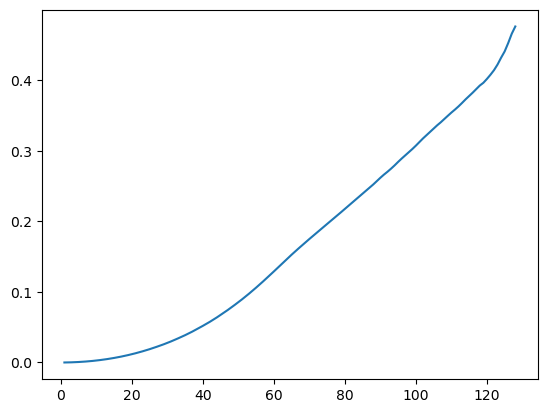

In [6]:
plt.plot(timestep,k.var(0))

In [9]:
n_atoms = 124
dt = np.arange(1, 129, 1)
n_runs = 100
box_size = [10,10,10]

#int_scat = np.zeros((n_runs,len(dt),len(q_points)))

#var_est = np.zeros((len(dt),len(q_points)))

N = np.zeros(len(dt))



for j in tqdm(range(n_runs)):
    steps = walk(n_atoms, dt, seed=np.random.RandomState(j))
    cum_steps = np.cumsum(steps, axis=1)
    disp_3d = []
    n_i = np.array([])
    for i, n in enumerate(dt):
        disp = np.concatenate([cum_steps[:, np.newaxis, i],
                                np.subtract(cum_steps[:, i + 1:], cum_steps[:, :-(i + 1)])],
                                axis=1) % box_size # Modulus operator for periodic boundary conditions
        disp_3d.append(disp)

100%|██████████| 100/100 [00:04<00:00, 24.27it/s]


In [44]:
k.shape

(100, 128)

In [14]:
std_num.shape

(128,)

In [26]:
n_atoms = 124
dt = np.arange(1, 129, 1)
n_runs = 1
box_size = [10,10,10]



N = np.zeros(len(dt))

for j in tqdm(range(n_runs)):
    cum_steps = walk(n_atoms, dt, seed=np.random.RandomState(j))
    disp_3d_2 = []
    n_i = np.array([])
    for i, n in enumerate(dt):
        disp = np.concatenate([cum_steps[:, np.newaxis, i],
                                np.subtract(cum_steps[:, i + 1:], cum_steps[:, :-(i + 1)])],
                                axis=1) 
        disp_3d_2.append(disp)

100%|██████████| 1/1 [00:00<00:00, 59.52it/s]


In [23]:
for i in range(len(dt)):
    print(dt[-1]/dt[i]*124)

15872.0
7936.0
5290.666666666666
3968.0
3174.4
2645.333333333333
2267.428571428571
1984.0
1763.5555555555554
1587.2
1442.909090909091
1322.6666666666665
1220.923076923077
1133.7142857142856
1058.1333333333332
992.0
933.6470588235294
881.7777777777777
835.3684210526316
793.6
755.8095238095237
721.4545454545455
690.0869565217391
661.3333333333333
634.88
610.4615384615385
587.8518518518518
566.8571428571428
547.3103448275862
529.0666666666666
512.0
496.0
480.969696969697
466.8235294117647
453.48571428571427
440.88888888888886
428.972972972973
417.6842105263158
406.97435897435895
396.8
387.1219512195122
377.90476190476187
369.1162790697674
360.72727272727275
352.7111111111111
345.04347826086956
337.70212765957444
330.66666666666663
323.91836734693874
317.44
311.2156862745098
305.2307692307692
299.47169811320754
293.9259259259259
288.58181818181816
283.4285714285714
278.45614035087715
273.6551724137931
269.0169491525424
264.5333333333333
260.1967213114754
256.0
251.93650793650792
248.0
244.

In [27]:
std_est = np.zeros(len(dt))

for i in range (len(dt)):
    std_est[i] = np.var(disp_3d_2[i][:,:,0])/(dt[-1]/dt[i]*124)

In [86]:
std_est

array([0.00020886, 0.00023703, 0.00024563, 0.00024798, 0.00024791,
       0.00024716, 0.00024588, 0.0002447 , 0.00024392, 0.00024336,
       0.00024275, 0.00024222, 0.00024167, 0.0002412 , 0.00024117,
       0.00024082, 0.00024045, 0.00024035, 0.00024064, 0.00024085,
       0.00024141, 0.00024207, 0.00024303, 0.00024408, 0.0002452 ,
       0.00024663, 0.0002482 , 0.00024985, 0.00025141, 0.00025319,
       0.00025498, 0.00025668, 0.00025881, 0.00026106, 0.00026308,
       0.0002653 , 0.00026752, 0.00026993, 0.00027262, 0.00027518,
       0.00027787, 0.00028096, 0.00028421, 0.00028759, 0.00029113,
       0.00029472, 0.00029775, 0.00030075, 0.00030415, 0.00030745,
       0.00031082, 0.00031466, 0.00031864, 0.00032243, 0.00032608,
       0.00032945, 0.00033252, 0.00033603, 0.00033955, 0.00034337,
       0.00034746, 0.00035185, 0.00035632, 0.00036083, 0.00036495,
       0.00036905, 0.0003733 , 0.00037736, 0.00038215, 0.00038716,
       0.0003926 , 0.00039824, 0.00040444, 0.00041137, 0.00041

In [92]:
k.shape

(100, 128)

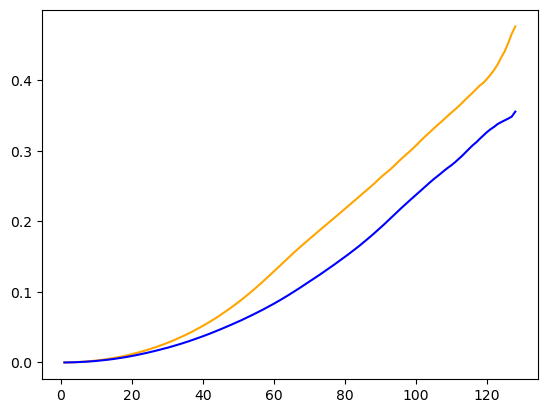

In [28]:
std_num = k.var(0)

plt.plot(dt,std_num, color = 'orange')
plt.plot(dt,std_est, color = 'blue') # Run estimated lots of times 


# Numerical variance (1000 runs)

In [93]:
# einsum dot product improvement

# numerical variance

n_atoms = 124
dt = np.arange(1, 129, 1)
n_runs = 1000
box_size = [10,10,10]

int_scat_num = np.zeros((n_runs,len(dt),len(q_points)))


for j in tqdm(range(n_runs)):
    steps = walk(n_atoms, dt, seed=np.random.RandomState(j))
    cum_steps = np.cumsum(steps, axis=1)
    disp_3d = []
    n_i = np.array([])
    for i, n in enumerate(dt):
        disp = np.concatenate([cum_steps[:, np.newaxis, i],
                                np.subtract(cum_steps[:, i + 1:], cum_steps[:, :-(i + 1)])],
                                axis=1) % box_size # Modulus operator for periodic boundary conditions
        disp_3d.append(disp)
        n_i = np.append(n_i, dt[-1] / n * n_atoms)

        step1 = np.exp(1j*np.einsum('ijk,lk->ijl', disp, q_points))

        int_scat_num[j,i,:] = np.mean(np.mean(step1, axis = 1), axis = 0)

  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/8y/ppth74md47d_wyx004p8vy6h0000gp/T/ipykernel_1833/1741978334.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  int_scat_num[j,i,:] = np.mean(np.mean(step1, axis = 1), axis = 0)
  1%|          | 6/1000 [00:03<10:14,  1.62it/s]


KeyboardInterrupt: 

In [97]:
# For saving
#np.save('1000run_scatfunc.npy',int_scat_num)
int_scat_num = np.load('1000run_scatfunc.npy')

Numerical variance, take variance across runs axis

In [102]:
print(int_scat_num.shape)

var_num = np.var(int_scat_num,axis = 0)

(1000, 128, 35)


In [103]:
mean_disp = np.zeros((128,3))

for i in range(0,len(disp_3d)):
    mean_disp[i]= np.array(disp_3d[i]).reshape(-1,3).mean(axis = 0)

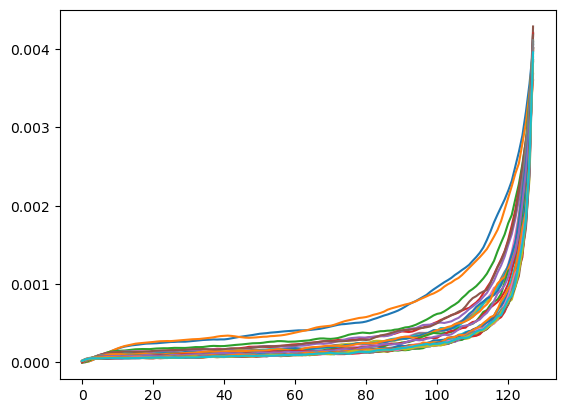

In [104]:
for x in range(5,len(q_points)):
    plt.plot(var_num[:,x])

In [66]:
var_est[:,20]

array([0.70852485, 0.91624568, 0.97659082, 0.99207127, 0.99757759,
       0.99939291, 0.99988587, 0.99998531, 0.99992048, 0.99979171,
       0.99988659, 0.99999796, 0.99999608, 0.99999828, 0.99999876,
       0.99995362, 0.9999873 , 0.99998081, 0.99996198, 0.99973615,
       0.99994923, 0.99998769, 0.99984677, 0.99979172, 0.99983042,
       0.99981007, 0.99982726, 0.99975854, 0.99986755, 0.99972245,
       0.99986275, 0.99980307, 0.99994147, 0.99988496, 0.99993613,
       0.99986994, 0.99968309, 0.99922886, 0.99946685, 0.99967176,
       0.99986955, 0.99990398, 0.99989545, 0.99987052, 0.99958508,
       0.99976939, 0.99976486, 0.99986706, 0.99973358, 0.99998477,
       0.99999408, 0.99993948, 0.99997978, 0.99993332, 0.99989521,
       0.99992421, 0.99983832, 0.99982567, 0.99974287, 0.99988336,
       0.99987602, 0.99976149, 0.99983037, 0.99999665, 0.99992496,
       0.99994861, 0.99998523, 0.99998016, 0.99988615, 0.99998216,
       0.99999209, 0.99992608, 0.99946617, 0.99922569, 0.99951

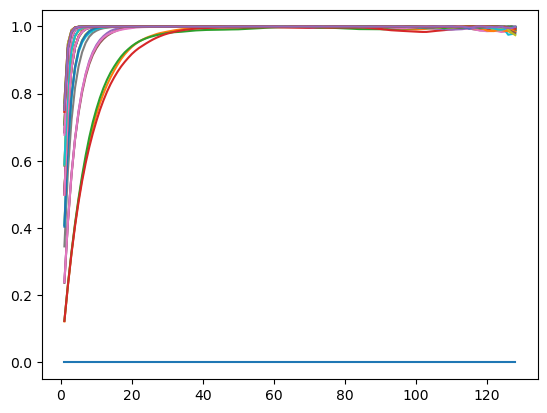

In [62]:
for x in range(0,len(q_points)):
    plt.plot(dt,var_est[:,x])

In [40]:
#np.save('1000_run_rw_35qpoints.npy', int_scat)

import ipywidgets as widgets

In [65]:
int_scat[:,:,20].T

array([[ 5.39881591e-01],
       [ 2.89400396e-01],
       [ 1.52936780e-01],
       [ 8.88997779e-02],
       [ 4.90534290e-02],
       [ 2.43257060e-02],
       [ 1.06829995e-02],
       [ 3.55102640e-03],
       [ 7.79008117e-03],
       [ 6.67648283e-03],
       [ 5.58185908e-03],
       [ 8.63967594e-04],
       [ 1.90398992e-03],
       [ 2.52050158e-04],
       [-6.66633087e-06],
       [-4.62250284e-03],
       [-3.38593021e-03],
       [ 4.20144946e-03],
       [ 8.54883172e-04],
       [ 5.96943270e-03],
       [ 2.60517800e-03],
       [-3.44938533e-03],
       [-2.15769018e-03],
       [-1.43561979e-05],
       [ 5.64770593e-03],
       [ 3.42103786e-03],
       [-2.15631106e-03],
       [-6.39631035e-03],
       [-6.37533672e-03],
       [-4.12246586e-03],
       [-5.23802467e-03],
       [-1.30181276e-02],
       [-6.36623534e-03],
       [-9.64249721e-03],
       [-7.83147439e-03],
       [-2.14257752e-03],
       [ 4.47298949e-03],
       [ 1.73633473e-02],
       [ 1.7

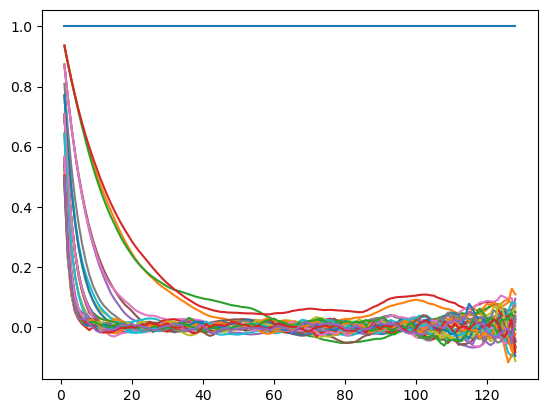

In [64]:
for i in range(0,len(q_points)):
    plt.plot(dt,int_scat[:,:,i].T)

In [41]:
chosen_q_point = 15

def plotting_widg(chosen_q_point):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (18,5))
    ax1.set_title('Uncertainty propogation vs timestep')
    ax1.plot(int_scat_num[:,:,chosen_q_point].T, 'b', alpha = 0.2)
    ax2.set_title('Standard deviation as a function of timestep')
    ax2.plot(dt,np.std(int_scat_num[:,:,chosen_q_point], axis = 0))
    cov = np.cov(int_scat_num[:,:,chosen_q_point].T)
    ax3.contourf(*np.meshgrid(dt, dt), cov, levels=20)
    fig.colorbar(ax3.contourf(*np.meshgrid(dt, dt), cov, levels=20))
    ax3.set_title('Covariance matrix as a function of timestep')
    fig.suptitle(f'Q-point: {q_points[chosen_q_point]}')

widgets.interact(plotting_widg, chosen_q_point = widgets.IntSlider(min=0, max=34, step=1, value=15))

interactive(children=(IntSlider(value=15, description='chosen_q_point', max=34), Output()), _dom_classes=('wid…

<function __main__.plotting_widg(chosen_q_point)>

In [22]:
int_scat.shape

(100, 128, 35)

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.0, 1000.0)

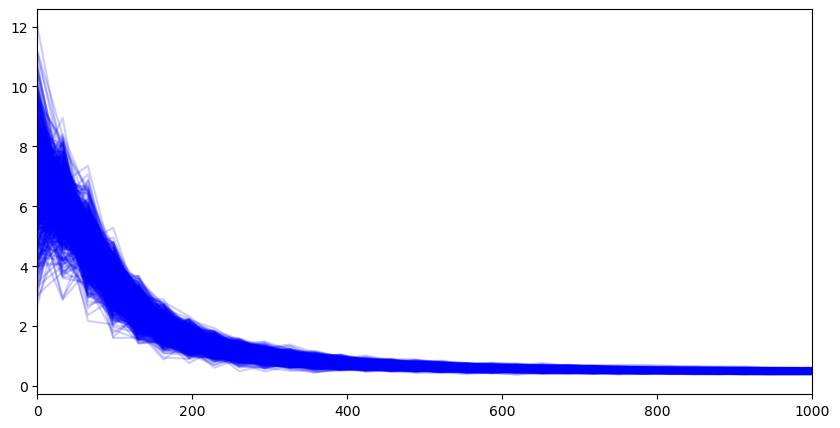

In [45]:
omega = np.linspace(0.0, 2 * np.pi / 1, len(int_scat_num[1]))


fig, ax = plt.subplots(1,1, figsize = (10,5))

s_q = np.fft.fft(int_scat_num,axis = 1)

ax.plot(omega*658.2119, s_q[:,:,4].T, 'b', alpha = 0.2)
ax.set_xlim(0, 1000)

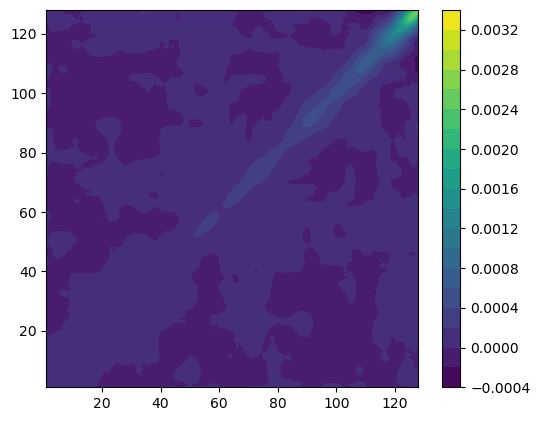

In [29]:
cov = np.cov(int_scat[:,:,10].T)


plt.subplots(figsize=(6, 4.9))
plt.contourf(*np.meshgrid(dt, dt), cov, levels=20)
plt.colorbar()
plt.show()

Text(0.5, 1.0, 'Mean STD as a function of q_point')

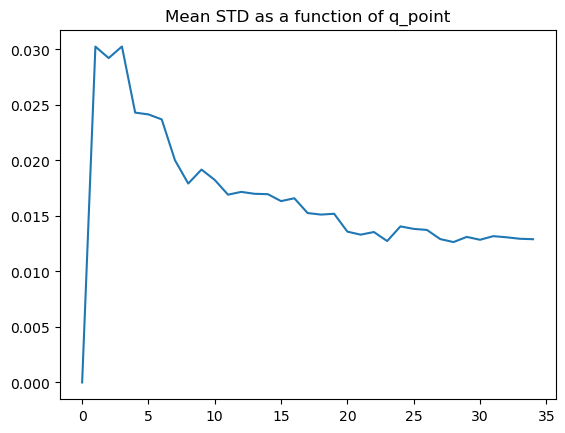

In [25]:
plt.plot(range(0,35),np.mean(np.std(int_scat[:,:,:], axis = 0), axis = 0))
plt.title('Mean STD as a function of q_point')

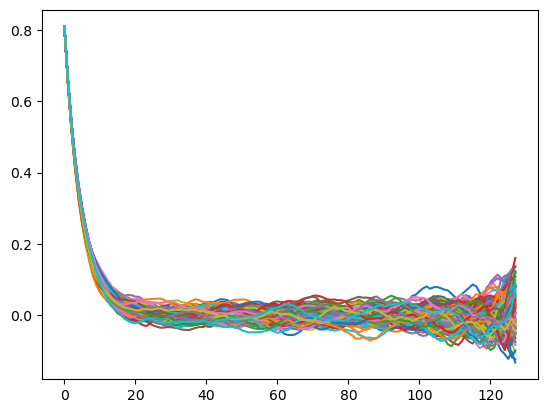

In [31]:
plt.plot(int_scat[:,:,7].T)
plt.show()